# This Notebook runs the KMode experiments with various feature groups - demographics, demographics+CHW, demographics+CHW+SDoH

## Install packages

In [ ]:
!pip install kmodes

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from itertools import combinations

from sklearn.metrics.cluster import adjusted_rand_score
from scipy.stats import mode
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [ ]:
path = '../data/sinai_synthetic_data.csv'
data = pd.read_csv(path)
print(data.shape)
data = data.drop(data[data['day_readmit']==2].index,axis=0)
print(f'Removed patient records where day_readmit value =2.\nUnique values in day_readmit column are - {data["day_readmit"].unique()}')

(2177, 91)
Removed patient records where day_readmit value =2.
Unique values in day_readmit column are - [0 1]


## Feature groups definition

In [ ]:
Groups={'Tracking' : ['new_patient_1','new_patient_2','new_patient_3'],
        'Contact' :['sum_contact_attempts_calc','time_spent_1','spoke_patient_yes','sumContacts_1 call','sumContacts_2 calls',
          'sumContacts_3 calls','sumContacts_4+','sumContacts_no calls'],
        'Demo' : ['age', 'comorbidity','sumComorbidities','race_black african american','race_hispanic','race_other',
                'language_non english','sex_gender_female','hypertension_yes','diabetes_yes','asthma_x_no', 'referrals_yesno_na',
                'type_sw_referral_ed','type_sw_referral_high risk admit','type_sw_referral_other','health_insurance_na',
                'health_insurance_public','health_insurance_uninsured', 'asthma_x_yes'],
        'Social_Determinant' : ['sdoh_pcp_0.0','sdoh_pcp_1.0','sdoh_ins_0.0','sdoh_ins_1.0','sdoh_housing_0.0',
                      'sdoh_housing2_0.0','food_security_0.0','food_security_1.0','sdoh_util_0.0',
                      'sdoh_util_1.0','sdoh_trans_0.0','sdoh_trans_1.0','sdoh_employ_1.0','sdoh_employ_4.0',
                      'sdoh_dv_1.0','hiv_test_interest_1.0','covid_vax_signup_1.0','sdoh_diabetes_1.0','sdoh_asthma1_1.0',
                      'sdoh_alc_1.0','sdoh_alc_na','sdoh_substance_1.0','sdoh_substance_2.0','sdoh_emotional_1.0',
                      'sdoh_emotional_2.0','sdoh_emotional_na','healthedneeds_0.0','healthedneeds_1.0',#'sdoh_yesno_0.0',
                      'sdoh_yesno_1.0','any_unmet_needs_0.0','any_unmet_needs_1.0','referrals_yesno_0.0',
                      'referrals_yesno_1.0', 'covid_vax_signup_na', 'covid_vax_signup_0.0', 'sdoh_asthma1_na',
                      'sdoh_pcp_na', 'sdoh_housing2_na', 'sdoh_ins_na', 'sdoh_trans_na', 'any_unmet_needs_na',
                      'sdoh_alc_3.0', 'sdoh_util_na', 'sdoh_diabetes_na', 'sdoh_housing2_1.0', 'covid_vax_signup_na',
                      'sdoh_asthma1_0.0', 'sdoh_employ_na', 'sdoh_diabetes_0.0', 'hiv_test_interest_na',
                      'hiv_test_interest_0.0', 'food_security_na', 'sdoh_dv_na'],
        'Followup':['total_time_spent','contact_attempts'],#, 'engaged_yes'],
        'ClassLabel':['day_readmit']
}
Demographics=Groups['Tracking']+Groups['Demo']
CHW=Groups['Followup']+Groups['Contact']
SDoH=Groups['Social_Determinant']
ClassLabel=Groups['ClassLabel']
All=Demographics+CHW+SDoH


FeatureGroups={'Demographics':Demographics,
               'CHW':CHW,
               'SDoH':SDoH,
               'All':All,
               'ClassLabel':ClassLabel
              }
numerical_features=['age','sum_contact_attempts_calc', 'time_spent_1', 'total_time_spent']

## User Defined helper functions

In [ ]:
def equal_frequncy_bins(data, num_bins,labels=[],feature=''):
  column_name=feature+'_categories'
  data[column_name] = pd.cut(data[feature], bins=num_bins, labels=labels)

def plot_distribution(data, feature, ax):
  title = 'Distribution of ' + feature
  xlabel = feature
  data[feature].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel('Count')

def optimal_kmodes_value_calculation(data, max_number_of_clusters=2, n_init = 5, init = 'random'):
  k_cost = []
  K = [i for i in range(1,max_number_of_clusters)]
  #print(K)
  for cluster in K:
    kmodes = KModes(n_clusters=cluster, n_init=n_init, init=init)
    kmodes.fit_predict(data)
    k_cost.append(kmodes.cost_)

  #Plot elbow graph
  plt.figure(figsize = (10,6))
  plt.plot(K, k_cost, 'b.-')
  plt.xlabel("Number of clusters")
  plt.ylabel("Cost")
  plt.title("Elbow plot")
  plt.show()

def run_optimal_kmodes_experiments(data, optimal_k, n_init=5, init="random", iterations=2):
  cluster_assignments = []

  for _ in range(iterations):
    kmodes = KModes(n_clusters=optimal_k, n_init=n_init, init=init)
    clusters = kmodes.fit_predict(data)
    cluster_assignments.append(clusters)

  ari_scores = []
  for i,j in combinations(range(len(cluster_assignments)),2):
    ari_scores.append(adjusted_rand_score(cluster_assignments[i], cluster_assignments[j]))

  average_ariscore = np.mean(ari_scores)
  standard_deviation_ariscore = np.std(ari_scores)

  return cluster_assignments, ari_scores, average_ariscore, standard_deviation_ariscore

def plot_average_aris(average_ariscore, standard_deviation_ariscore):
  # Plot the ari scores
  ari_data = {
  'Feature Set': ['Demographics', 'Demographics + CHW', 'Demographics + CHW + SDoH'],
  'Average ARI': average_ariscore,
  'Std Deviation': standard_deviation_ariscore
  }

  ari_df = pd.DataFrame(ari_data)

  plt.figure(figsize=(10, 6))
  plt.errorbar(ari_df['Feature Set'], ari_df['Average ARI'], yerr=ari_df['Std Deviation'], fmt='o', capsize=5, linestyle='None', color='b', ecolor='r')
  plt.xlabel('Feature Set')
  plt.ylabel('Average ARI')
  plt.title('ARI Scores for Different Feature Sets')
  plt.grid(True)
  plt.show()


In [ ]:
# Function to summarize clusters with min, max for all features, average for numerical, and percentage for categorical
def summarize_clusters(data, cluster_column, numerical_features):
  summary_dict = {cluster_column: [], 'Feature': [], 'Min': [], 'Max': [], 'Avg/Mode/Percentage': []}
  numerical_features=['age','sum_contact_attempts_calc', 'time_spent_1', 'total_time_spent']

  for feature in data.columns:

    if feature != cluster_column:
      grouped = data.groupby(cluster_column)[feature]

      for cluster, group in grouped:
        summary_dict[cluster_column].append(cluster)
        summary_dict['Feature'].append(feature)

        # Calculate Min and Max for all features
        summary_dict['Min'].append(group.min())
        summary_dict['Max'].append(group.max())


        if feature in numerical_features:
            # Calculate Average for numerical features
            summary_dict['Avg/Mode/Percentage'].append(round(group.mean(), 2))
        else:
            # Calculate percentage of each category for categorical features
            value_counts = group.value_counts(normalize=True) * 100
            
            percentage_str = {round(pct,2) for cat, pct in value_counts.items() if cat == 1}
            summary_dict['Avg/Mode/Percentage'].append(percentage_str)

  return pd.DataFrame(summary_dict)

In [ ]:
def generate_summary_html(summaryData,features_to_investigate):
  html_content = "<html><head><title>Cluster Summary</title></head><body>"

  clusters = summaryData['DemographicsCHWSDoH_cluster'].unique()

  for cluster in clusters:
      html_content += f"<h2>Cluster {cluster} Summary:</h2>"
      html_content += "<table border='1'><tr><th>Feature</th><th>Min</th><th>Max</th><th>Avg/Mode/Percentage</th></tr>"
      cluster_data = summaryData[summaryData['DemographicsCHWSDoH_cluster'] == cluster]
      for feature in features_to_investigate:
          feature_data = cluster_data[cluster_data['Feature'] == feature]
          if not feature_data.empty:
              min_value = feature_data['Min'].values[0]
              max_value = feature_data['Max'].values[0]
              avg_mode_percentage_value = feature_data['Avg/Mode/Percentage'].values[0]
              html_content += f"<tr><td>{feature}</td><td>{min_value}</td><td>{max_value}</td><td>{avg_mode_percentage_value}</td></tr>"
      html_content += "</table><br>"

  html_content += "</body></html>"

  # Save the HTML content to a file
  htmlfilepath = '../results/html/cluster_summary1.html'
  with open(htmlfilepath, "w") as file:
      file.write(html_content)

  print("HTML summary has been created and saved as 'cluster_summary1.html'.")

In [ ]:
def plot_cluster_summary(summaryData,features_to_investigate):
  clusters = summaryData['DemographicsCHWSDoH_cluster'].unique()
  for cluster in clusters:
    Features = []
    Values=[]
    cluster_data = summaryData[summaryData['DemographicsCHWSDoH_cluster'] == cluster]
    for feature in features_to_investigate:
      feature_data = cluster_data[cluster_data['Feature'] == feature]
      if not feature_data.empty:
        avg_mode_percentage_value = feature_data['Avg/Mode/Percentage'].values[0]
        if isinstance(avg_mode_percentage_value, set):
          avg_mode_percentage_value = next(iter(avg_mode_percentage_value))
        Features.append(feature)
        Values.append(avg_mode_percentage_value)

    data = {
      'Feature': Features,
      'Cluster': Values
    }

    df = pd.DataFrame(data)

    # Plotting Cluster 0
    plt.figure(figsize=(14, 10))
    plt.subplot(1, 1, 1)
    sns.barplot(x=df['Feature'], y=df['Cluster'])
    plt.title(f'Cluster {cluster} Summary', fontsize=16)
    plt.xticks(rotation=90, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

In [ ]:
def combined_plot_cluster_summary(summaryData, features_to_investigate):
    combined_data = []
    palette = sns.color_palette("Blues", n_colors=len(summaryData['DemographicsCHWSDoH_cluster'].unique()))


    # Collect data for all clusters
    clusters = summaryData['DemographicsCHWSDoH_cluster'].unique()
    for cluster in clusters:
        cluster_data = summaryData[summaryData['DemographicsCHWSDoH_cluster'] == cluster]
        for feature in features_to_investigate:
            feature_data = cluster_data[cluster_data['Feature'] == feature]
            if not feature_data.empty:
                avg_mode_percentage_value = feature_data['Avg/Mode/Percentage'].values[0]
                if isinstance(avg_mode_percentage_value, set):
                    avg_mode_percentage_value = next(iter(avg_mode_percentage_value))
                combined_data.append({'Feature': feature, 'Cluster': cluster, 'Value': avg_mode_percentage_value})

    # Create a DataFrame from the combined data
    df = pd.DataFrame(combined_data)

    # Plotting all clusters in one chart
    plt.figure(figsize=(20, 10))
    sns.barplot(x='Feature', y='Value', hue='Cluster', data=df,palette=palette)
    plt.title('Cluster Summary', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Average')
    plt.tight_layout()
    plt.show()

## Convert Numerical features to categories

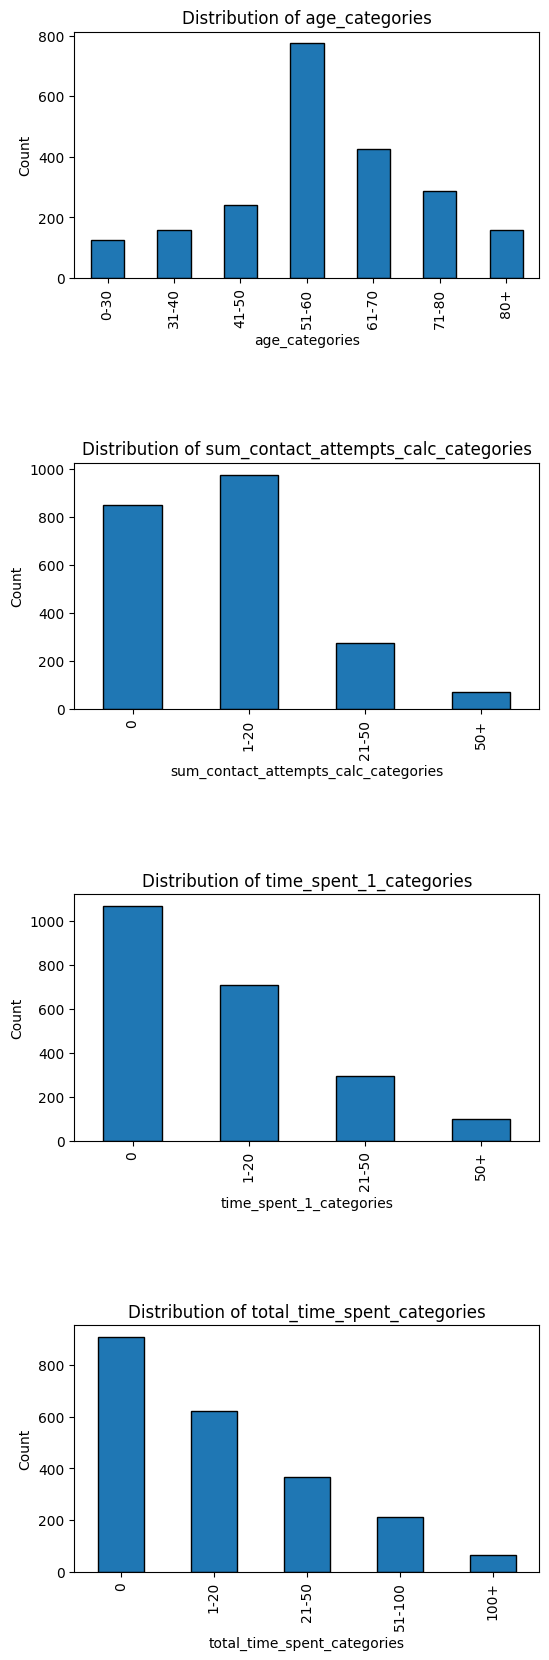

In [ ]:
num_features=len(numerical_features)

fig, ax = plt.subplots(nrows=num_features, ncols=1, figsize=(6, 5 * num_features), edgecolor='black',gridspec_kw={'hspace': 0.75})

# convert numerical feature to categorical features
for i,feature in enumerate(numerical_features):
  if feature == 'age':
    bins = [-1, 30, 40, 50, 60, 70, 80, 100]
    labels = ['0-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']

  elif feature == 'sum_contact_attempts_calc':
    bins = [-1, 0, 20, 50, 300]
    labels = ['0','1-20', '21-50', '50+']

  elif feature == 'time_spent_1':
    bins = [-1, 0, 20, 50, 400]
    labels = ['0','1-20', '21-50', '50+']

  else:
    bins = [-1, 0, 20, 50, 100, 600]
    labels = ['0','1-20', '21-50', '51-100', '100+']

  equal_frequncy_bins(data,bins,labels=labels,feature=feature)
  plot_distribution(data,feature +'_categories', ax[i])
  processedData = data.drop(feature, axis=1)

## Run KModes Experiments

### Determine optimal k Value

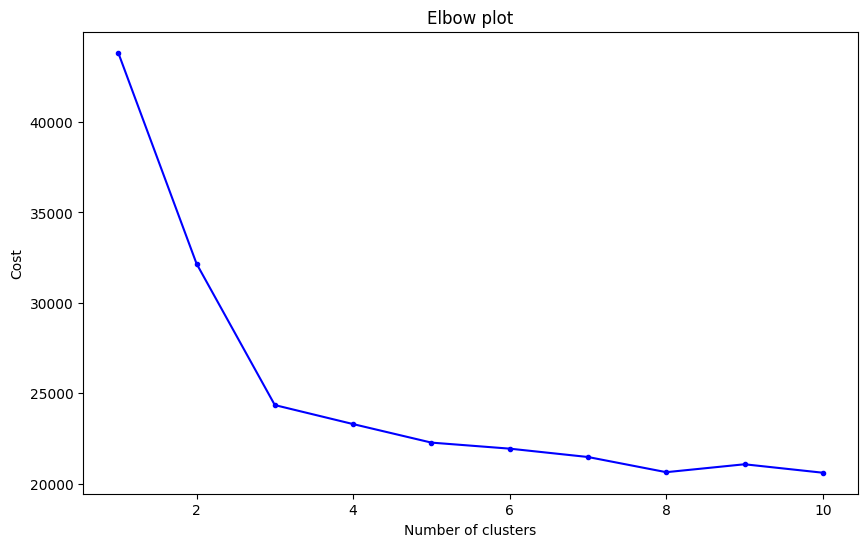

In [ ]:
processedData = processedData.drop(ClassLabel, axis=1, errors='ignore')
optimal_kmodes_value_calculation(processedData, max_number_of_clusters=11)

## Execute KModes experiments

In [ ]:
FeatureGroups={'Demographics':Demographics,
               'CHW':CHW,
               'SDoH':SDoH,
               'All':All,
               'ClassLabel':ClassLabel
              }

featureGroup = []
features_to_remove = ['age','sum_contact_attempts_calc', 'time_spent_1', 'total_time_spent']
average_ariscores = []
standard_deviation_ariscores = []

optimal_k = 3
number_of_experiments = 30
n_init = 5
cluster_assignments = {'Demographics':[],
                       'DemographicsCHW':[],
                       'DemographicsCHWSDoH':[]}
dictionaryKey = ''

for key in FeatureGroups:
  if key not in ('ClassLabel', 'All'):

    # Remove specified features
    FeatureGroups[key] = [feature for feature in FeatureGroups[key] if feature not in features_to_remove]
    dictionaryKey += key

    # Accumulate remaining features
    featureGroup += FeatureGroups[key]
    cluster_assignments[dictionaryKey],ari_scores, average_ariscore, standard_deviation_ariscore = run_optimal_kmodes_experiments(processedData[featureGroup], optimal_k, n_init=n_init, iterations=number_of_experiments)
    average_ariscores.append(average_ariscore)
    standard_deviation_ariscores.append(standard_deviation_ariscore)

    # calculate_average_ari_score

    print(f"Average ARI using {dictionaryKey} features = {average_ariscore}")
    print(f"Std Deviation using {dictionaryKey} features = {standard_deviation_ariscore}\n")
    processedData[dictionaryKey+'_cluster'] = mode(cluster_assignments[dictionaryKey], axis=0).mode.flatten()

Average ARI using Demographics features = 0.47263652272392925
Std Deviation using Demographics features = 0.1859429270692441

Average ARI using DemographicsCHW features = 0.6994052671696461
Std Deviation using DemographicsCHW features = 0.1257667349873163

Average ARI using DemographicsCHWSDoH features = 0.9846362929523136
Std Deviation using DemographicsCHWSDoH features = 0.014277905573480012



3


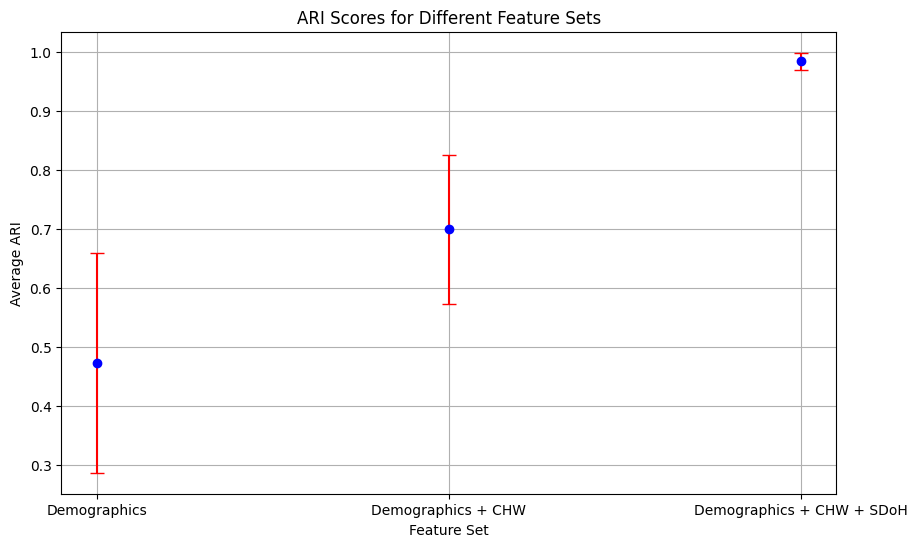

In [ ]:
print(len(standard_deviation_ariscores))
plot_average_aris(average_ariscores, standard_deviation_ariscores)

## Save the clustered data

In [ ]:
processedData.set_index(data.index)
processedData['age']=data['age']
processedData['sum_contact_attempts_calc']=data['sum_contact_attempts_calc']
processedData['time_spent_1']=data['time_spent_1']
processedData['total_time_spent']=data['total_time_spent']
processedData['day_readmit']=data['day_readmit']

In [ ]:
processedData['DemographicsCHWSDoH_cluster'].unique()

array([1, 0, 2])

In [ ]:
todaysDate=pd.to_datetime('today').date()
path = '../results/csv/Clustered'+str(todaysDate)+'.csv'
processedData.to_csv(path)

## Summarize Clusters

In [ ]:
# Generate Summary
features_to_investigate = ['age','sumComorbidities', 'sum_contact_attempts_calc','day_readmit','total_time_spent','race_black african american', 'race_hispanic',
       'race_other','spoke_patient_yes','hypertension_yes', 'diabetes_yes','asthma_x_yes','engaged_yes','sdoh_yesno_1.0']
cluster_columns = ['Demographics_cluster','DemographicsCHW_cluster','DemographicsCHWSDoH_cluster']
summaryData = summarize_clusters(processedData, 'DemographicsCHWSDoH_cluster', cluster_columns)

# Create HTML content with tables
generate_summary_html(summaryData,features_to_investigate)

HTML summary has been created and saved as 'cluster_summary1.html'.


### Plot Summary Results

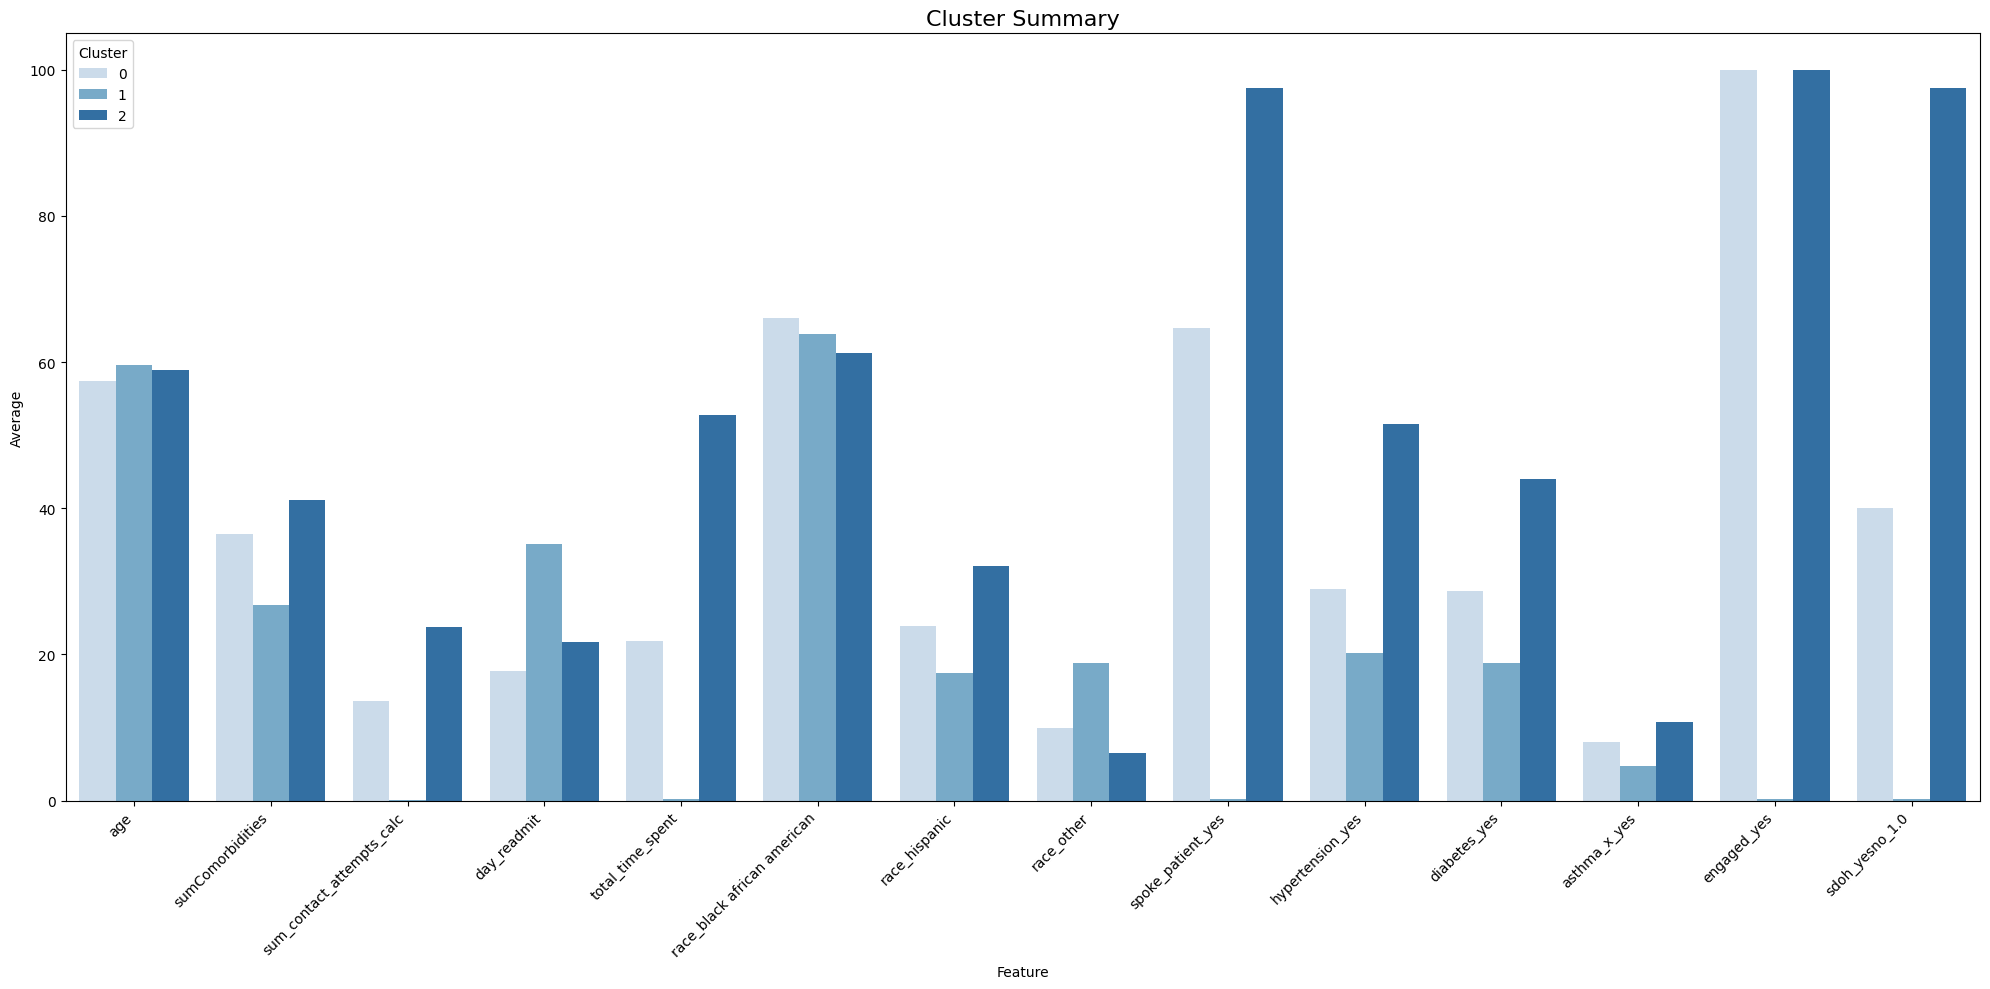

In [ ]:
combined_plot_cluster_summary(summaryData,features_to_investigate)
# summaryData